In [1]:
%matplotlib inline
import obspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates


from hydrophone_data_processing import load, preprocessing, tempmatch

import matplotlib.ticker as ticker

class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz

In [2]:
detectfiles = '/media/sda/data/borehole/detections/*.csv'
det = load.import_detections(detectfiles)

In [3]:
# det.time.apply(pd.to_datetime)

In [4]:
paths = ['/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138']

In [5]:
day138 = load.import_corrected_data_for_single_day(paths=paths)

In [6]:
# day138.decimate(factor=10)

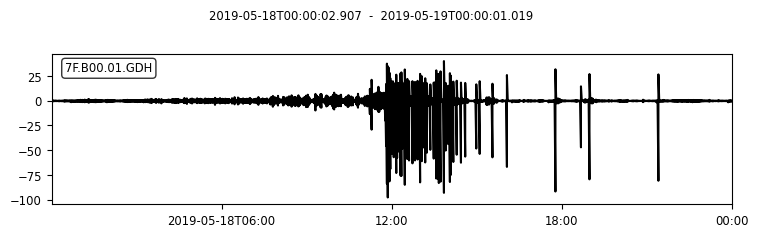

In [7]:
x = day138[0].plot()

In [8]:
# h1.data.min()

In [9]:
h1 = day138[0]

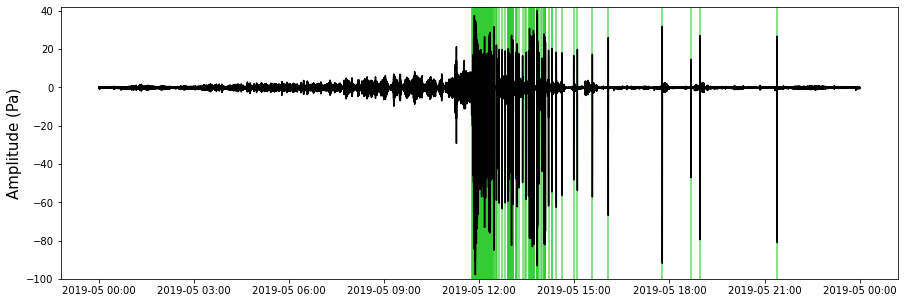

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

data = det[det.time.between('2019-05-18', '2019-05-19')].copy()

x = data.time
y = np.ones_like(x)*500
ax.plot([x, x], [-y, y], color='limegreen', alpha=0.75)

ax.plot(h1.times('matplotlib'), h1.data, color='black')

ax.set_ylim(-100, 42)
ax.set_ylabel('Amplitude (Pa)', fontsize=15)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m %H:%M:%S'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m %H:%M'))

In [11]:
starttime = obspy.UTCDateTime('2019-05-18T14:30:00')
endtime = obspy.UTCDateTime('2019-05-18T14:40:00')
tempraw = day138.copy().trim(starttime=starttime, endtime=endtime)
tempraw = tempmatch.digest_data(tempraw)
temp = tempmatch.make_template(hole='B')

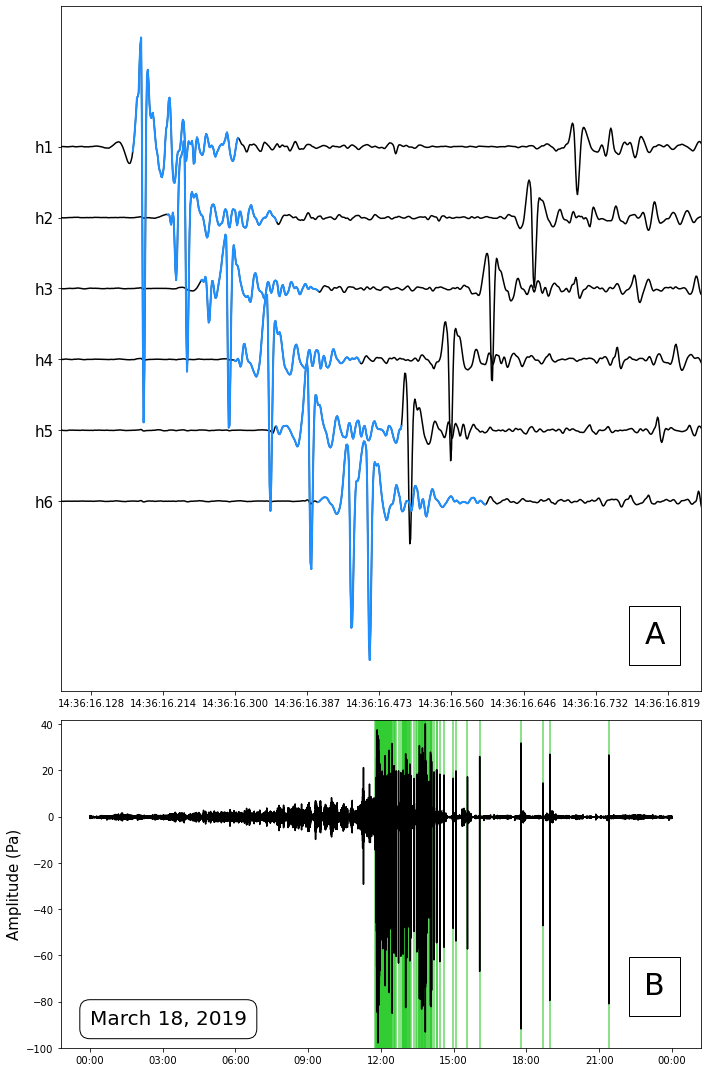

In [42]:
###############
#   template  #
###############
fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,2), (2, 0), colspan=3, )

ax = (ax1, ax2)

for n, tr in enumerate(tempraw):
    ax[0].plot(tr.times('matplotlib'), tr.data-10*n, color='black')
    
for n, tr in enumerate(temp):
    ax[0].plot(tr.times('matplotlib'), tr.data-10*n, color='dodgerblue', linewidth=2)
    
yticks = np.array([0, 10, 20, 30, 40, 50])*-1
ax[0].set_yticks(yticks)
ylabels = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
ax[0].set_yticklabels(ylabels, fontsize=15)
    
ax[0].set_xlim(temp[0].times('matplotlib').min()-1e-6, temp[-1].times('matplotlib').max()+3e-6)
# ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m %H:%M'))
ax[0].xaxis.set_major_formatter(PrecisionDateFormatter('%H:%M:%S.{ms}'))

###################
#   all day 138   #
###################
data = det[det.time.between('2019-05-18', '2019-05-19')].copy()

x = data.time
y = np.ones_like(x)*500
ax[1].plot([x, x], [-y, y], color='limegreen', alpha=0.75)

ax[1].plot(h1.times('matplotlib'), h1.data, color='black')

ax[1].set_ylim(-100, 42)
ax[1].set_ylabel('Amplitude (Pa)', fontsize=15)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m %H:%M:%S'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5')
ax[1].text(s='March 18, 2019', fontsize=20, x=h1.times('matplotlib').min(), y=-90, bbox=bbox)

bbox = dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.5')
# ax[0].text(s='A', fontsize=20, x=temp[-1].times('matplotlib').max()+2.25e-6, y=-70, bbox=bbox)
fig.text(s='A', fontsize=30, x=0.9, y=0.4, bbox=bbox)
fig.text(s='B', fontsize=30, x=0.9, y=0.075, bbox=bbox)

fig.tight_layout()
fig.savefig('figures/bubbles_time_series_day138_AND_bubble_templates_with_reflections.pdf', bbox_inches='tight')

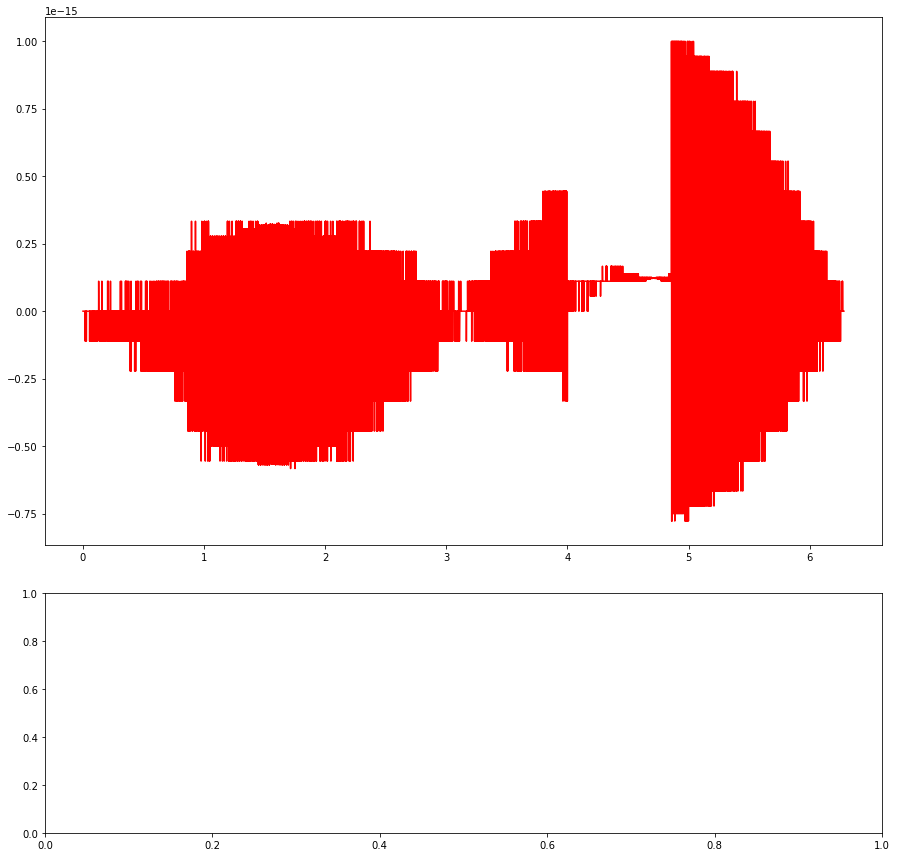

In [22]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((3,2), (2, 0), colspan=3, )
ax2 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan=2)

x = np.linspace(0, 2*np.pi, 10000)
y = np.cos(x) + np.cos(x+np.pi)
ax2.plot(x, y, color='red')